In [11]:
import yfinance as yf
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model, regularizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

In [6]:
# Выбираем акции кампании google
ticker = "GOOGL"

# задание временного интервала цены акций
start_date = "2014-01-01"
end_date = "2024-04-01"

# Получение данных с помощью Yahoo Finance API
df = yf.download(ticker, start=start_date, end=end_date)
df.describe()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
count,2577.000000,2577.000000,2577.000000,2577.000000,2577.000000,2.577000e+03
mean,70.875260,71.620688,70.145593,70.902445,70.727312,3.760979e+07
std,37.886449,38.337086,37.470366,37.909693,37.816054,1.984046e+07
min,24.962000,25.014000,24.545500,24.853001,24.791613,9.312000e+06
25%,38.917500,39.145000,38.513500,38.849998,38.754036,2.600400e+07
50%,57.767502,58.674999,57.331001,58.042000,57.898632,3.215400e+07
75%,102.900002,104.360001,101.754997,103.005997,102.751572,4.229400e+07
max,152.800003,153.779999,151.429993,153.509995,153.130814,2.571620e+08


In [7]:
# Выбор нужных столбцов
column = ['Open', 'Adj Close', 'Volume']
df_new = df[column]
df_new

,Open,Adj Close,Volume
Date,,,
2014-01-02,27.914413,27.787050,72783144
2014-01-03,27.902903,27.584349,66601332
2014-01-06,27.853104,27.891897,70701228
2014-01-07,28.153152,28.429604,102001896
2014-01-08,28.678679,28.488766,89610300
...,...,...,...
2024-03-22,149.119995,150.397598,29175700
2024-03-25,149.940002,149.699326,19229300
2024-03-26,150.220001,150.297836,22149100


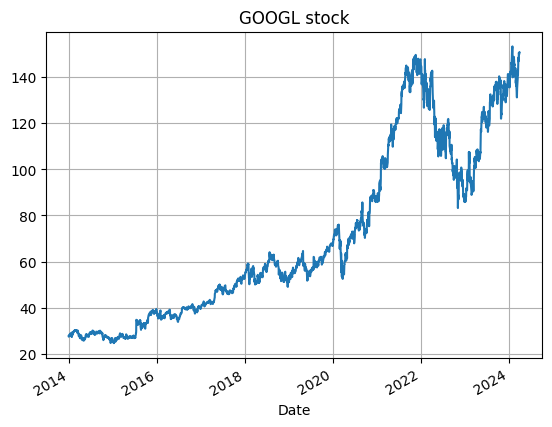

In [14]:
# Визуализация изменения цены акций на заданном интервале
startDate = datetime.datetime(2014, 1, 1)
endDate = datetime.datetime(2024, 4, 1)
google_data = yf.Ticker('GOOGL')
google_df = google_data.history(start=startDate, end=endDate)
google_df['Close'].plot(title="GOOGL stock")
plt.grid(True)

In [15]:
# Выбор нужных столбцов
column = ['Open', 'Adj Close', 'Volume']
df_new = df[column]

# Преобразование данных
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df_new)

# Параметры модели
sequence_length = 10
n_features = 2
n_attention_heads = 3
l1_reg = 0.001
l2_reg = 0.001
momentum = 0.9

# Подготовка данных
def prepare_data(data):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length, :-1])
        y.append(data[i+sequence_length, -2])  # Изменение индекса для предсказания столбца 'Adj Close'
    return np.array(X), np.array(y)

X, y = prepare_data(df_scaled)

# Разделение данных на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Рекуррентная модель с механизмом внимания и GRU
inputs = layers.Input(shape=(sequence_length, n_features))
attention = layers.MultiHeadAttention(num_heads=n_attention_heads, key_dim=64)(inputs, inputs)
gru_out = layers.GRU(64, return_sequences=True, kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(attention)
out = layers.Flatten()(gru_out)
out = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(out)
out = layers.Dense(1, kernel_regularizer=regularizers.l1_l2(l1=l1_reg, l2=l2_reg))(out)
model = Model(inputs, out)

# Компиляция модели с оптимизатором SGD с моментом
optimizer = tf.keras.optimizers.SGD(momentum=momentum)
model.compile(optimizer=optimizer, loss='mse')

# Обучение модели на тренировочных данных с использованием обратного вызова History
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1)

# Получение истории обучения
history_dict = history.history

# Предсказание на тестовых данных
y_pred = model.predict(X_test)

# Оценка модели
loss = model.evaluate(X_test, y_test) #Средняя квадратическая ошибка
r_squared = r2_score(y_test, y_pred) #Коэффициент детерминации
mae = mean_absolute_error(y_test, y_pred) #Среднее абсолютное значение разности между предсказанными значениями модели и их соответствующими истинными значениями
mape = mean_absolute_percentage_error(y_test, y_pred) #Средняя абсолютная процентная ошибка между предсказанными и истинными значениями
spearman_corr, _ = spearmanr(y_test, y_pred) # Коэффициент Спирмена

print("Spearman's correlation coefficient:", spearman_corr)
print("R-squared:", r_squared)
print("MAE:", mae)
print("MAPE:", mape)
print("Test Loss:", loss)



Epoch 1/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 2.1101 - val_loss: 1.8131
Epoch 2/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7471 - val_loss: 1.5529
Epoch 3/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.4923 - val_loss: 1.3158
Epoch 4/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.2605 - val_loss: 1.1000
Epoch 5/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.0498 - val_loss: 0.9045
Epoch 6/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.8592 - val_loss: 0.7290
Epoch 7/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6888 - val_loss: 0.5737
Epoch 8/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.5387 - val_loss: 0.4387
Epoch 9/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.4085 - val_loss: 0.3234
Epoch 10/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.2982 - val_loss: 0.2276
Epoch 11/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.2072 - val_loss: 0.1510
Epoch 12/30
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.1

In [ ]:
# Проверка наличия ключей 'loss' и 'val_loss'
if 'loss' in history_dict and 'val_loss' in history_dict:
    # Графики потерь на обучающем и валидационном наборах
    plt.plot(history_dict['loss'], label='Training Loss')
    plt.plot(history_dict['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
else:
    print("Ошибка: Не удалось найти историю потерь в обучении модели.")

In [ ]:
# Вычисление ошибок
errors = y_pred.flatten() - y_test

# Построение гистограммы распределения ошибок
plt.figure(figsize=(10, 6))
plt.hist(errors, bins=50, edgecolor='k')
plt.title('Распределение ошибок')
plt.xlabel('Ошибка')
plt.ylabel('Частота')
plt.grid(True)
plt.show()

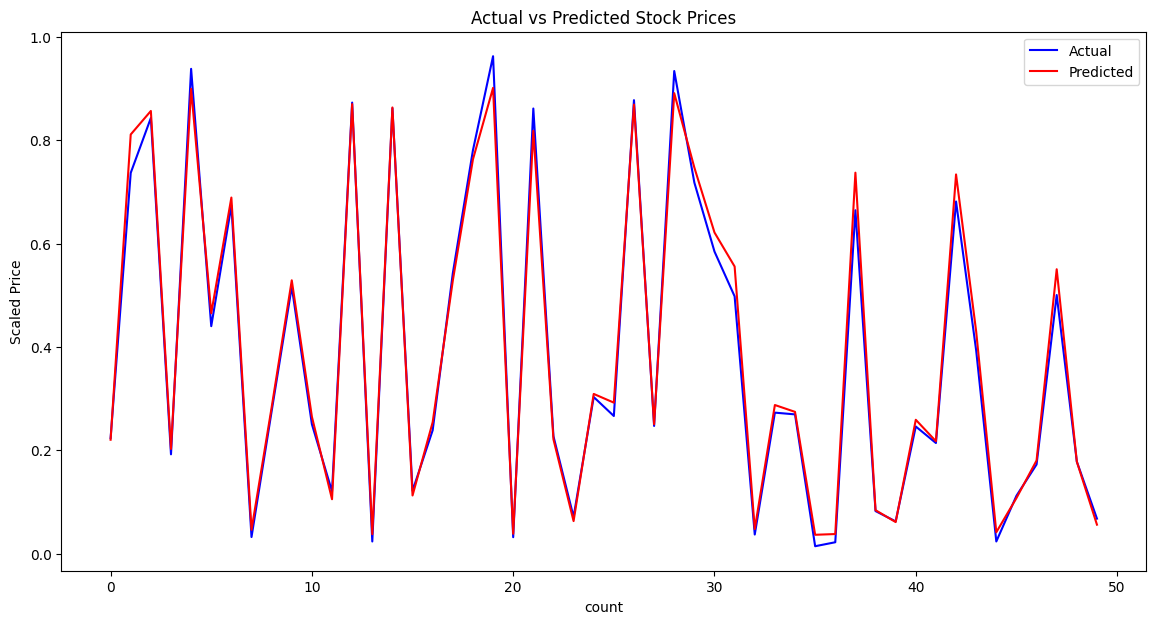

In [16]:
# Сравнение предсказанных и действительных значений
plt.figure(figsize=(14, 7))
plt.plot(y_test[0:50], label='Actual', color='blue')
plt.plot(y_pred[0:50], label='Predicted', color='red')

plt.title('Actual vs Predicted Stock Prices')
plt.xlabel('count')
plt.ylabel('Scaled Price')
plt.legend()
plt.show()

In [ ]:
# Рассчитываем корреляцию между фактическими и предсказанными значениями
correlation = np.corrcoef(y_test.flatten(), y_pred.flatten())[0, 1]

# Создаем график корреляции
plt.figure(figsize=(8, 6))
plt.scatter(y_test.flatten(), y_pred.flatten(), color='blue', alpha=0.5)
plt.title('Correlation Plot')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.text(0.1, 0.9, f'Correlation: {correlation:.2f}', transform=plt.gca().transAxes)
plt.show()

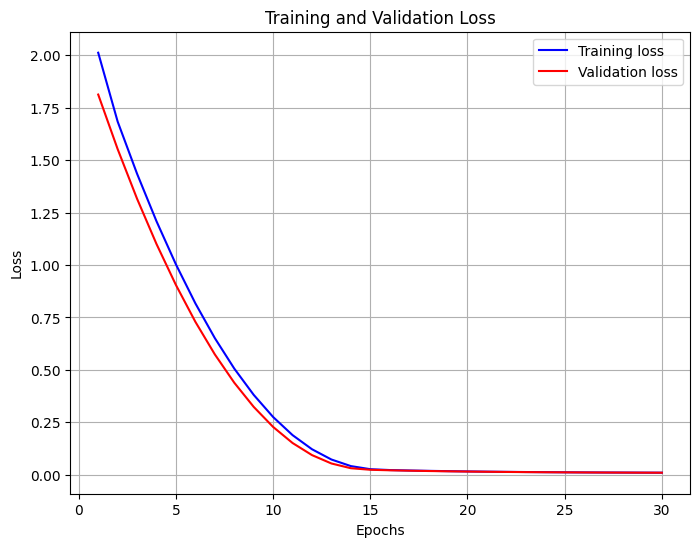

In [17]:
# Получаем историю потерь
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(train_loss) + 1)

# Создаем график
plt.figure(figsize=(8, 6))
plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
